In [1]:
# this is a basic working example of sentiment analysis
# I am using TF GPU

In [78]:
# checking GPU
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)


Num GPUs Available:  1


In [2]:
# import all
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import json
from glob import glob
import gc


In [3]:
# check tf version
tf.__version__

'2.2.0'

In [4]:
import platform

print(platform.python_version())

3.6.9


In [5]:
# read all the input data files, tab seperated values
data_txt = glob('/tf/deep_learning/sentiment_analysis/data/*.txt')
data_tsv = glob('/tf/deep_learning/sentiment_analysis/data/*.tsv')
model_file = '/tf/deep_learning/sentiment_analysis/lib/model'
header_list = ["comments", "sentiment"]

In [6]:

# # read all the data using windows encoding and python engine. Else it will give error for windows files
# # l = [pd.read_csv(f, sep='\t', names=header_list, encoding = "ISO-8859-1", engine='python') for f in data_txt]
# l = [pd.read_csv(f, sep='\t', names=header_list) for f in data_txt]
# data_txt = pd.concat(l, axis=0)
# print('total length of the training data_txt %s'%(len(data_txt)))

# # read all the data using windows encoding and python engine. Else it will give error for windows files
# # l = [pd.read_csv(f, sep='|', names=header_list, encoding = "ISO-8859-1", engine='python') for f in data_tsv]
# l = [pd.read_csv(f, sep='|', names=header_list) for f in data_tsv]
# data_tsv = pd.concat(l, axis=0)
# print('total length of the training data_tsv %s'%(len(data_tsv)))
# # total data
# frames = [data_txt, data_tsv]
# data = pd.concat(frames)
# print('total length of the training data %s'%(len(data)))

# # drop the base data and free the memory
# del [[l,data_txt, data_tsv]]
# gc.collect()

In [7]:
# new data
data = pd.read_csv('/tf/deep_learning/sentiment_analysis/data/sentiment_all_clean_multi.csv')
data = data[['comments', 'sentiment']].dropna()
data = (data[data['comments'] != 'oct'])
data

,comments,sentiment
0,so there is no way for me to plug it in here i...,0
1,good case excellent value,1
2,great for the jawbone,1
3,tied to charger for conversations lasting more...,0
4,the mic is great,1
...,...,...
52995,loved this showsmart acting smart dialog great...,1
52996,for long time i have not seen such a good fant...,1
52997,andy goldsworthy is a taoist master of the fir...,1
52998,vonneguts words are best experienced on paper ...,1


In [8]:
# lets do data explore
# how many neg/pos
# looks like evenly split
data.groupby('sentiment').count()

,comments
sentiment,
0,26500
1,26498


In [9]:
print(data.shape)
print(data.dtypes)

(52998, 2)
comments     object
sentiment     int64
dtype: object


In [10]:
# check the review length
max_len = data['comments'].astype('str').map(len).max()
min_len = data['comments'].astype('str').map(len).min()
print(max_len, min_len)


13309 6


In [11]:
data.loc[data['comments'].astype('str').map(len) < 10]
# need data clean

,comments,sentiment
827,good case,1
857,it works,1
877,excellent,1
1165,delicious,1
2155,horrible,0
2162,awful,0
2198,so bad,0
2493,see it,1
2907,hated it,0


In [12]:
# remove all NaN values
data.dropna(subset = ["comments"], inplace=True)
# drop duplicates
data.drop_duplicates(subset=None, keep='first', inplace=True)

In [13]:
# pd.options.plotting.backend = "plotly"
# data[['review_len']].plot(title="Pandas Backend Example", template="simple_white",
#               labels=dict(index="time", value="money", variable="option"))

In [14]:
# get training data, use balanced split
X_train, X_test, y_train, y_test = train_test_split(data["comments"], data["sentiment"], test_size=0.20, random_state=42, stratify=data['sentiment'])
# get test and validation data, use balanced split
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.25, random_state=42, stratify=y_test)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)
# drop the base data and free the memory
# del [[l,data]]
del [[data]]
gc.collect()


(42036,)
(42036,)
(7882,)
(7882,)
(2628,)
(2628,)


0

In [15]:
# check if the data is balanced
print(y_train.value_counts())
print(y_test.value_counts())
print(y_val.value_counts())

1    21093
0    20943
Name: sentiment, dtype: int64
1    3955
0    3927
Name: sentiment, dtype: int64
1    1319
0    1309
Name: sentiment, dtype: int64


In [16]:
# embedding using TF lib
vocab_size = 10000
# max_review_length = 200
max_review_length = 250
oov_tok = "<OOV>"
embedding_dim = 16
# embedding_dim = 32
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

In [17]:
# saving the tokenizer, for the API
tokenizer_json = tokenizer.to_json()
with open(model_file+'/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))
word_index = tokenizer.word_index
# training data
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padding = pad_sequences(train_sequences, truncating='post', padding='post', maxlen=max_review_length)
# test data
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padding = pad_sequences(test_sequences, truncating='post', padding='post', maxlen=max_review_length)
# validation data
validation_sequences = tokenizer.texts_to_sequences(X_val)
validation_padding = pad_sequences(validation_sequences, truncating='post', padding='post', maxlen=max_review_length)


In [18]:
# Need this block to get it to work with TensorFlow 2.x, converting to NP array
# training
training_padded = np.array(train_padding)
training_labels = np.array(y_train)
# testing
testing_padded = np.array(test_padding)
testing_labels = np.array(y_test)
# validation
validation_padded = np.array(validation_padding)
validation_labels = np.array(y_val)

In [19]:
# check out the data
training_padded

array([[ 996,   51,    9, ...,    0,    0,    0],
       [  11,   14,   95, ...,    0,    0,    0],
       [   1,  299,  176, ..., 1026,    6, 2132],
       ...,
       [6664,    1,    1, ...,    0,    0,    0],
       [  11,   18, 1507, ...,    0,    0,    0],
       [   9,   91,  199, ...,    0,    0,    0]], dtype=int32)

In [40]:
# # creating simple model, without early stopping
# # increse the batch size if you need to run it faster. optimal batch size is between 1 to 32
# batch_size=10
# num_epochs = 45
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_review_length),
#     tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.Dense(24, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
#     ])
# #Compile with binary_crossentropy as it's a binary predictions with adam optimizer, not setting the learning rate
# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# history = model.fit(training_padded, training_labels, batch_size=batch_size, epochs=num_epochs, validation_data=(validation_padded, validation_labels), verbose=2)
# #save the model
# model.save("%s/sentiment_dnn.h5" %model_file)
# print(model.summary())

# # Final evaluation of the model
# score, acc = model.evaluate(testing_padded, testing_labels, batch_size=batch_size)
# print(score, acc)

Epoch 1/45
4204/4204 - 23s - loss: 0.3913 - accuracy: 0.8268 - val_loss: 0.3062 - val_accuracy: 0.8756
Epoch 2/45
4204/4204 - 24s - loss: 0.2594 - accuracy: 0.8942 - val_loss: 0.3042 - val_accuracy: 0.8687
Epoch 3/45
4204/4204 - 25s - loss: 0.2283 - accuracy: 0.9089 - val_loss: 0.3129 - val_accuracy: 0.8687
Epoch 4/45
4204/4204 - 23s - loss: 0.2086 - accuracy: 0.9188 - val_loss: 0.3189 - val_accuracy: 0.8706
Epoch 5/45
4204/4204 - 23s - loss: 0.1951 - accuracy: 0.9256 - val_loss: 0.3396 - val_accuracy: 0.8676
Epoch 6/45
4204/4204 - 22s - loss: 0.1834 - accuracy: 0.9313 - val_loss: 0.3414 - val_accuracy: 0.8664
Epoch 7/45
4204/4204 - 23s - loss: 0.1750 - accuracy: 0.9354 - val_loss: 0.3747 - val_accuracy: 0.8588
Epoch 8/45
4204/4204 - 23s - loss: 0.1675 - accuracy: 0.9392 - val_loss: 0.3760 - val_accuracy: 0.8596
Epoch 9/45
4204/4204 - 23s - loss: 0.1612 - accuracy: 0.9412 - val_loss: 0.3939 - val_accuracy: 0.8543
Epoch 10/45
4204/4204 - 23s - loss: 0.1527 - accuracy: 0.9437 - val_loss:

KeyboardInterrupt: 

In [27]:
# creating checkpoint
filepath=(model_file+"\weights.best.hdf5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


In [23]:
# creating simple model 240-1,0.1
batch_size=10
num_epochs = 25
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_review_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(240, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
#     tf.keras.layers.Dense(1, activation='linear')
])
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

model.fit(training_padded, training_labels, batch_size=batch_size, epochs=num_epochs, validation_data=(validation_padded, validation_labels), callbacks=callbacks_list, verbose=2)
#save the model
model.save(filepath)
print(model.summary())

# Final evaluation of the model
score, acc = model.evaluate(testing_padded, testing_labels, batch_size=batch_size)
print(score, acc)

Epoch 1/25

Epoch 00001: val_accuracy improved from -inf to 0.74239, saving model to /tf/deep_learning/sentiment_analysis/lib/model\weights.best.hdf5
4204/4204 - 23s - loss: 0.4372 - accuracy: 0.8115 - val_loss: 0.5170 - val_accuracy: 0.7424
Epoch 2/25

Epoch 00002: val_accuracy improved from 0.74239 to 0.80213, saving model to /tf/deep_learning/sentiment_analysis/lib/model\weights.best.hdf5
4204/4204 - 23s - loss: 0.3362 - accuracy: 0.8682 - val_loss: 0.6781 - val_accuracy: 0.8021
Epoch 3/25

Epoch 00003: val_accuracy improved from 0.80213 to 0.84285, saving model to /tf/deep_learning/sentiment_analysis/lib/model\weights.best.hdf5
4204/4204 - 23s - loss: 0.3226 - accuracy: 0.8779 - val_loss: 0.3969 - val_accuracy: 0.8428
Epoch 4/25

Epoch 00004: val_accuracy improved from 0.84285 to 0.85008, saving model to /tf/deep_learning/sentiment_analysis/lib/model\weights.best.hdf5
4204/4204 - 23s - loss: 0.3007 - accuracy: 0.8952 - val_loss: 0.5304 - val_accuracy: 0.8501
Epoch 5/25

Epoch 00005

In [160]:
# creating simple model 240-1,0.0001

saveBestModel = tf.keras.callbacks.ModelCheckpoint(model_file+'sentiment_dnn_n240_lr0001.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', save_weights_only=False)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

batch_size=10
num_epochs = 50
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_review_length),
    tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.Dense(240, activation='relu'),
    tf.keras.layers.Dense(900, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(axis=1),
    tf.keras.layers.Dropout(0.50),
    tf.keras.layers.Dense(1, activation='sigmoid')
#     tf.keras.layers.Dense(1, activation='linear')
])
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

# model.fit(training_padded, training_labels, batch_size=batch_size, epochs=num_epochs, validation_data=(validation_padded, validation_labels), callbacks=callbacks_list, verbose=2)
model.fit(training_padded, training_labels, batch_size=batch_size, epochs=num_epochs, shuffle= True, validation_data=(validation_padded, validation_labels), callbacks=[saveBestModel, earlyStopping], verbose=2)
#save the model
# model.save(filepath)
model.save("%s/sentiment_dnn_n240_lr0001.h5" %model_file)
print(model.summary())

# Final evaluation of the model
score, acc = model.evaluate(testing_padded, testing_labels, batch_size=batch_size)
print(score, acc)

Epoch 1/50

Epoch 00001: val_accuracy improved from -inf to 0.85008, saving model to /tf/deep_learning/sentiment_analysis/lib/modelsentiment_dnn_n240_lr0001.h5
4204/4204 - 28s - loss: 0.5535 - accuracy: 0.7562 - val_loss: 0.3833 - val_accuracy: 0.8501
Epoch 2/50

Epoch 00002: val_accuracy improved from 0.85008 to 0.86758, saving model to /tf/deep_learning/sentiment_analysis/lib/modelsentiment_dnn_n240_lr0001.h5
4204/4204 - 29s - loss: 0.3799 - accuracy: 0.8458 - val_loss: 0.3419 - val_accuracy: 0.8676
Epoch 3/50

Epoch 00003: val_accuracy did not improve from 0.86758
4204/4204 - 29s - loss: 0.3462 - accuracy: 0.8610 - val_loss: 0.3345 - val_accuracy: 0.8619
Epoch 4/50

Epoch 00004: val_accuracy did not improve from 0.86758
4204/4204 - 30s - loss: 0.3194 - accuracy: 0.8739 - val_loss: 0.3382 - val_accuracy: 0.8554
Epoch 5/50

Epoch 00005: val_accuracy improved from 0.86758 to 0.87519, saving model to /tf/deep_learning/sentiment_analysis/lib/modelsentiment_dnn_n240_lr0001.h5
4204/4204 - 

In [163]:
# 1 -> positive
# 0 -> negative
def sentiment(score):
    new_score=[None] * (len(score))
    for position in range(len(score)):
        if score[position] >= 0.50:
            new_score[position]=1
        else:
            new_score[position]=0
    return(new_score)
# load the best model and check the accuracy
# load weights, not the model
# we can save the model and use it, which is a better solutions
# new_model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_review_length),
#     tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.Dense(700, activation='relu'),
#     tf.keras.layers.BatchNormalization(axis=1),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])
# new_model.load_weights("%s/sentiment_dnn_n240_lr0001.h5" %model_file)
# new_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# load the model

new_model = tf.keras.models.load_model("%s/sentiment_dnn_n240_lr0001.h5" %model_file)
scores = new_model.evaluate(testing_padded, testing_labels, batch_size=batch_size, verbose=2)
print(scores)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 10 samples")
predictions = model.predict(testing_padded)
print("predictions shape:", predictions.shape)
# pd.set_option('display.max_colwidth', None)
# print(X_test[:3])
# print(type(np.array(sentiment(predictions))))
# print(type(testing_labels[:10]))
# print(np.array(sentiment(predictions)))
# print(testing_labels[:10])

789/789 - 2s - loss: 0.3564 - accuracy: 0.8649
[0.3564104437828064, 0.8648819923400879]
accuracy: 86.49%
Generate predictions for 10 samples
predictions shape: (7882, 1)


Confusion matrix, without normalization
[[3368  559]
 [ 506 3449]]
Confusion matrix : 
 [[3368  559]
 [ 506 3449]]
Classification report : 
               precision    recall  f1-score   support

           0       0.87      0.86      0.86      3927
           1       0.86      0.87      0.87      3955

    accuracy                           0.86      7882
   macro avg       0.86      0.86      0.86      7882
weighted avg       0.86      0.86      0.86      7882



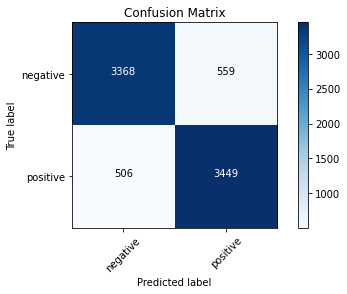

In [164]:
# confusion matrix
%matplotlib inline
from sklearn.metrics import confusion_matrix

import itertools
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true=testing_labels, y_pred=np.array(sentiment(predictions)),labels=[0,1])
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm_plot_labels = ['negative','positive']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
matrix = confusion_matrix(testing_labels,np.array(sentiment(predictions)),labels=[0,1])
print('Confusion matrix : \n',matrix)
matrix = classification_report(testing_labels,np.array(sentiment(predictions)),labels=[0,1])
print('Classification report : \n',matrix)

In [177]:
# try CNN
saveBestModel = tf.keras.callbacks.ModelCheckpoint(model_file+'sentiment_cnn_test.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', save_weights_only=False)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

batch_size=10
num_epochs = 50

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_review_length))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.BatchNormalization(axis=1))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(240, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
print(model.summary())
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(training_padded, training_labels, batch_size=batch_size, epochs=num_epochs, shuffle= True, validation_data=(validation_padded, validation_labels), callbacks=[saveBestModel, earlyStopping], verbose=2)
# evaluate
scores = model.evaluate(testing_padded, testing_labels, verbose=2)
print(scores)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_89 (Embedding)     (None, 250, 16)           160000    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 243, 32)           4128      
_________________________________________________________________
batch_normalization_42 (Batc (None, 243, 32)           972       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 121, 32)           0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 3872)              0         
_________________________________________________________________
dense_184 (Dense)            (None, 240)               929520    
_________________________________________________________________
dense_185 (Dense)            (None, 1)               

ValueError: Input 0 of layer conv2d_12 is incompatible with the layer: expected ndim=4, found ndim=3. Full shape received: [None, 250, 16]

In [51]:
# save the best DNN model and early stopping
# saveBestModel = tf.keras.callbacks.ModelCheckpoint(model_file+'sentiment_dnn_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
saveBestModel = tf.keras.callbacks.ModelCheckpoint(model_file+'sentiment_dnn_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', save_weights_only=False)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [52]:
# approach 2(85%)
# creating simple model
batch_size=1
num_epochs = 50
model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_review_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer='adam',metrics=['accuracy'])

history = model_2.fit(training_padded, training_labels, batch_size=batch_size, epochs=num_epochs, validation_data=(validation_padded, validation_labels), callbacks=[saveBestModel, earlyStopping], verbose=2)
# history = model_2.fit(training_padded, training_labels, batch_size=batch_size, epochs=num_epochs, validation_data=(validation_padded, validation_labels), verbose=2)
#save the model
model_2.save("%s/model_2sentiment_dnn.h5" %model_file)
print(model_2.summary())

# Final evaluation of the model
score, acc = model_2.evaluate(testing_padded, testing_labels, batch_size=batch_size)
print(score, acc)

Epoch 1/50

Epoch 00001: val_accuracy improved from -inf to 0.85807, saving model to /tf/deep_learning/sentiment_analysis/lib/modelsentiment_dnn_best.h5
42036/42036 - 206s - loss: 0.5896 - accuracy: 0.8026 - val_loss: 0.5683 - val_accuracy: 0.8581
Epoch 2/50

Epoch 00002: val_accuracy improved from 0.85807 to 0.86149, saving model to /tf/deep_learning/sentiment_analysis/lib/modelsentiment_dnn_best.h5
42036/42036 - 194s - loss: 0.5625 - accuracy: 0.8684 - val_loss: 0.5686 - val_accuracy: 0.8615
Epoch 3/50

Epoch 00003: val_accuracy did not improve from 0.86149
42036/42036 - 193s - loss: 0.5578 - accuracy: 0.8797 - val_loss: 0.5713 - val_accuracy: 0.8413
Epoch 4/50

Epoch 00004: val_accuracy did not improve from 0.86149
42036/42036 - 193s - loss: 0.5549 - accuracy: 0.8855 - val_loss: 0.5695 - val_accuracy: 0.8512
Epoch 5/50

Epoch 00005: val_accuracy did not improve from 0.86149
42036/42036 - 194s - loss: 0.5527 - accuracy: 0.8901 - val_loss: 0.5717 - val_accuracy: 0.8470
Epoch 6/50

Epo

In [56]:
# approach3
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_3_sentiment_dnn.h5", save_best_only=True)
saveBestModel = tf.keras.callbacks.ModelCheckpoint(model_file+'model_3_sentiment_dnn.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', save_weights_only=False)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
batch_size=1
num_epochs = 500
model_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_review_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer='adam',metrics=['accuracy'])

history = model_3.fit(training_padded, training_labels, batch_size=batch_size, epochs=num_epochs, validation_data=(validation_padded, validation_labels), callbacks=[saveBestModel, earlyStopping], verbose=2)
#save the model
model_3.save("%s/model_3_sentiment_dnn.h5" %model_file)
print(model_3.summary())

# Final evaluation of the model
score, acc = model_3.evaluate(testing_padded, testing_labels, batch_size=batch_size)
print(score, acc)

Epoch 1/500

Epoch 00001: val_accuracy improved from -inf to 0.85312, saving model to /tf/deep_learning/sentiment_analysis/lib/modelmodel_3_sentiment_dnn.h5
42036/42036 - 182s - loss: 0.5890 - accuracy: 0.8071 - val_loss: 0.5723 - val_accuracy: 0.8531
Epoch 2/500

Epoch 00002: val_accuracy improved from 0.85312 to 0.86301, saving model to /tf/deep_learning/sentiment_analysis/lib/modelmodel_3_sentiment_dnn.h5
42036/42036 - 181s - loss: 0.5613 - accuracy: 0.8715 - val_loss: 0.5747 - val_accuracy: 0.8630
Epoch 3/500

Epoch 00003: val_accuracy did not improve from 0.86301
42036/42036 - 181s - loss: 0.5564 - accuracy: 0.8806 - val_loss: 0.5689 - val_accuracy: 0.8615
Epoch 4/500

Epoch 00004: val_accuracy did not improve from 0.86301
42036/42036 - 181s - loss: 0.5539 - accuracy: 0.8880 - val_loss: 0.5738 - val_accuracy: 0.8345
Epoch 5/500

Epoch 00005: val_accuracy did not improve from 0.86301
42036/42036 - 181s - loss: 0.5510 - accuracy: 0.8952 - val_loss: 0.5764 - val_accuracy: 0.8352
Epoc

In [57]:
# approach4
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_4_sentiment_dnn.h5", save_best_only=True)
saveBestModel = tf.keras.callbacks.ModelCheckpoint(model_file+'model_4_sentiment_dnn.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', save_weights_only=False)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
batch_size=1
num_epochs = 50
model_4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_review_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

history = model_4.fit(training_padded, training_labels, batch_size=batch_size, epochs=num_epochs, validation_data=(validation_padded, validation_labels), verbose=2)
#save the model
model_4.save("%s/model_4_sentiment_dnn.h5" %model_file)
print(model_4.summary())

# Final evaluation of the model
score, acc = model_4.evaluate(testing_padded, testing_labels, batch_size=batch_size)
print(score, acc)

Epoch 1/50
42036/42036 - 180s - loss: 0.5886 - binary_accuracy: 0.5018 - val_loss: 0.5688 - val_binary_accuracy: 0.5019
Epoch 2/50
42036/42036 - 181s - loss: 0.5619 - binary_accuracy: 0.5018 - val_loss: 0.5790 - val_binary_accuracy: 0.5019
Epoch 3/50
42036/42036 - 181s - loss: 0.5576 - binary_accuracy: 0.5035 - val_loss: 0.5761 - val_binary_accuracy: 0.5030
Epoch 4/50
42036/42036 - 180s - loss: 0.5548 - binary_accuracy: 0.5065 - val_loss: 0.5714 - val_binary_accuracy: 0.5084
Epoch 5/50
42036/42036 - 181s - loss: 0.5522 - binary_accuracy: 0.5124 - val_loss: 0.5716 - val_binary_accuracy: 0.5148
Epoch 6/50
42036/42036 - 180s - loss: 0.5499 - binary_accuracy: 0.5171 - val_loss: 0.5723 - val_binary_accuracy: 0.5194
Epoch 7/50
42036/42036 - 180s - loss: 0.5487 - binary_accuracy: 0.5222 - val_loss: 0.5743 - val_binary_accuracy: 0.5213
Epoch 8/50
42036/42036 - 180s - loss: 0.5472 - binary_accuracy: 0.5224 - val_loss: 0.5670 - val_binary_accuracy: 0.5240
Epoch 9/50
42036/42036 - 180s - loss: 0.

In [58]:
# approach 5
# creating simple model
# callback for best model
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_5_best.h5", save_best_only=True)
saveBestModel = tf.keras.callbacks.ModelCheckpoint(model_file+'model_5_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', save_weights_only=False)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
batch_size=1
num_epochs = 500
model_5 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_review_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(2400, activation='relu'),
    tf.keras.layers.Dropout(0.50),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer='adam',metrics=['accuracy'])

history = model_5.fit(training_padded, training_labels, batch_size=batch_size, epochs=num_epochs, validation_data=(validation_padded, validation_labels), callbacks=[saveBestModel, earlyStopping], verbose=2)
# history = model_5.fit(training_padded, training_labels, batch_size=batch_size, epochs=num_epochs, validation_data=(validation_padded, validation_labels), callbacks=[checkpoint_cb], verbose=2)
# rollback to the best model
model_5 = tf.keras.models.load_model("model_5_best.h5")
#save the model
model_5.save("%s/model_5_sentiment_dnn.h5" %model_file)
print(model_5.summary())

# Final evaluation of the model
score, acc = model_5.evaluate(testing_padded, testing_labels, batch_size=batch_size)
print(score, acc)

Epoch 1/500

Epoch 00001: val_accuracy improved from -inf to 0.84399, saving model to /tf/deep_learning/sentiment_analysis/lib/modelmodel_5_best.h5
42036/42036 - 188s - loss: 0.5911 - accuracy: 0.8025 - val_loss: 0.5764 - val_accuracy: 0.8440
Epoch 2/500

Epoch 00002: val_accuracy did not improve from 0.84399
42036/42036 - 189s - loss: 0.5727 - accuracy: 0.8444 - val_loss: 0.5955 - val_accuracy: 0.8124
Epoch 3/500

Epoch 00003: val_accuracy did not improve from 0.84399
42036/42036 - 189s - loss: 0.5716 - accuracy: 0.8485 - val_loss: 0.5885 - val_accuracy: 0.8086
Epoch 4/500

Epoch 00004: val_accuracy improved from 0.84399 to 0.84513, saving model to /tf/deep_learning/sentiment_analysis/lib/modelmodel_5_best.h5
42036/42036 - 188s - loss: 0.5684 - accuracy: 0.8560 - val_loss: 0.5889 - val_accuracy: 0.8451
Epoch 5/500

Epoch 00005: val_accuracy did not improve from 0.84513
42036/42036 - 188s - loss: 0.5684 - accuracy: 0.8578 - val_loss: 0.5729 - val_accuracy: 0.8444
Epoch 6/500

Epoch 000

In [59]:
# approach 6
# creating simple model
# callback for best model
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_6_best.h5", save_best_only=True)
saveBestModel = tf.keras.callbacks.ModelCheckpoint(model_file+'model_6_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', save_weights_only=False)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_6_best.h5", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

batch_size=1
num_epochs = 500
model_6 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_review_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
#     tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer='adam',metrics=['accuracy'])

# history = model_5.fit(training_padded, training_labels, batch_size=batch_size, epochs=num_epochs, validation_data=(validation_padded, validation_labels), callbacks=[saveBestModel, earlyStopping], verbose=2)
# history = model_6.fit(training_padded, training_labels, batch_size=batch_size, epochs=num_epochs, validation_data=(validation_padded, validation_labels), callbacks=[checkpoint_cb], verbose=2)
history = model_6.fit(training_padded, training_labels, batch_size=batch_size, epochs=num_epochs, validation_data=(validation_padded, validation_labels), callbacks=[checkpoint_cb, early_stopping_cb], verbose=2)
# rollback to the best model
# model_6 = tf.keras.models.load_model("model_6_best.h5")
#save the model
model_6.save("%s/model_6_sentiment_dnn.h5" %model_file)
print(model_6.summary())

# Final evaluation of the model
score, acc = model_6.evaluate(testing_padded, testing_labels, batch_size=batch_size)
print(score, acc)

Epoch 1/500
42036/42036 - 183s - loss: 0.5892 - accuracy: 0.8071 - val_loss: 0.5693 - val_accuracy: 0.8508
Epoch 2/500
42036/42036 - 183s - loss: 0.5616 - accuracy: 0.8713 - val_loss: 0.5696 - val_accuracy: 0.8474
Epoch 3/500
42036/42036 - 182s - loss: 0.5570 - accuracy: 0.8815 - val_loss: 0.5697 - val_accuracy: 0.8482
Epoch 4/500
42036/42036 - 182s - loss: 0.5538 - accuracy: 0.8881 - val_loss: 0.5715 - val_accuracy: 0.8444
Epoch 5/500
42036/42036 - 182s - loss: 0.5519 - accuracy: 0.8918 - val_loss: 0.5722 - val_accuracy: 0.8512
Epoch 6/500
42036/42036 - 182s - loss: 0.5501 - accuracy: 0.8962 - val_loss: 0.5709 - val_accuracy: 0.8630
Epoch 7/500
42036/42036 - 182s - loss: 0.5484 - accuracy: 0.9004 - val_loss: 0.5741 - val_accuracy: 0.8402
Epoch 8/500
42036/42036 - 182s - loss: 0.5461 - accuracy: 0.9057 - val_loss: 0.5743 - val_accuracy: 0.8402
Epoch 9/500
42036/42036 - 182s - loss: 0.5449 - accuracy: 0.9076 - val_loss: 0.5724 - val_accuracy: 0.8588
Epoch 10/500
42036/42036 - 182s - los

In [61]:
# creating model with multiple dense layer
batch_size=1
num_epochs = 50
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("sentiment_multi_dnn.h5", save_best_only=True)
saveBestModel = tf.keras.callbacks.ModelCheckpoint(model_file+'sentiment_multi_dnn.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', save_weights_only=False)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_review_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(training_padded, training_labels, batch_size=batch_size, epochs=num_epochs, validation_data=(validation_padded, validation_labels), callbacks=[saveBestModel, earlyStopping], verbose=2)
# history = model.fit(training_padded, training_labels, batch_size=batch_size, epochs=num_epochs, validation_data=(validation_padded, validation_labels), verbose=2)
#save the model
model.save("%s/sentiment_multi_dnn.h5" %model_file)
print(model.summary())

# Final evaluation of the model
score, acc = model.evaluate(testing_padded, testing_labels, batch_size=batch_size)
print(score, acc)

Epoch 1/50

Epoch 00001: val_accuracy improved from -inf to 0.86720, saving model to /tf/deep_learning/sentiment_analysis/lib/modelsentiment_multi_dnn.h5
42036/42036 - 196s - loss: 0.3508 - accuracy: 0.8396 - val_loss: 0.3151 - val_accuracy: 0.8672
Epoch 2/50

Epoch 00002: val_accuracy improved from 0.86720 to 0.87139, saving model to /tf/deep_learning/sentiment_analysis/lib/modelsentiment_multi_dnn.h5
42036/42036 - 190s - loss: 0.2628 - accuracy: 0.8904 - val_loss: 0.2945 - val_accuracy: 0.8714
Epoch 3/50

Epoch 00003: val_accuracy did not improve from 0.87139
42036/42036 - 211s - loss: 0.2359 - accuracy: 0.9022 - val_loss: 0.3990 - val_accuracy: 0.8508
Epoch 4/50

Epoch 00004: val_accuracy did not improve from 0.87139
42036/42036 - 233s - loss: 0.2216 - accuracy: 0.9102 - val_loss: 0.3236 - val_accuracy: 0.8691
Epoch 5/50

Epoch 00005: val_accuracy did not improve from 0.87139
42036/42036 - 235s - loss: 0.2095 - accuracy: 0.9162 - val_loss: 0.3231 - val_accuracy: 0.8702
Epoch 6/50

E

In [62]:
# creating model V2
batch_size=1
num_epochs = 50
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("sentiment_multi_dnn_v2.h5", save_best_only=True)
saveBestModel = tf.keras.callbacks.ModelCheckpoint(model_file+'sentiment_multi_dnn_v2.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', save_weights_only=False)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_review_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.50),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(training_padded, training_labels, batch_size=batch_size, epochs=num_epochs, validation_data=(validation_padded, validation_labels), callbacks=[saveBestModel, earlyStopping], verbose=2)
# history = model.fit(training_padded, training_labels, batch_size=batch_size, epochs=num_epochs, validation_data=(validation_padded, validation_labels), verbose=2)
#save the model
model.save("%s/sentiment_multi_dnn_v2.h5" %model_file)
print(model.summary())

# Final evaluation of the model
score, acc = model.evaluate(testing_padded, testing_labels, batch_size=batch_size)
print(score, acc)

Epoch 1/50

Epoch 00001: val_accuracy improved from -inf to 0.81925, saving model to /tf/deep_learning/sentiment_analysis/lib/modelsentiment_multi_dnn_v2.h5
42036/42036 - 281s - loss: 0.3672 - accuracy: 0.8382 - val_loss: 0.4021 - val_accuracy: 0.8193
Epoch 2/50

Epoch 00002: val_accuracy improved from 0.81925 to 0.87405, saving model to /tf/deep_learning/sentiment_analysis/lib/modelsentiment_multi_dnn_v2.h5
42036/42036 - 261s - loss: 0.2811 - accuracy: 0.8873 - val_loss: 0.3249 - val_accuracy: 0.8740
Epoch 3/50

Epoch 00003: val_accuracy did not improve from 0.87405
42036/42036 - 247s - loss: 0.2575 - accuracy: 0.8988 - val_loss: 0.3398 - val_accuracy: 0.8699
Epoch 4/50

Epoch 00004: val_accuracy did not improve from 0.87405
42036/42036 - 243s - loss: 0.2435 - accuracy: 0.9071 - val_loss: 0.3389 - val_accuracy: 0.8691
Epoch 5/50

Epoch 00005: val_accuracy did not improve from 0.87405
42036/42036 - 251s - loss: 0.2373 - accuracy: 0.9108 - val_loss: 0.3435 - val_accuracy: 0.8626
Epoch 6

In [ ]:
# # creating LSTM model
# lstm_model = tf.keras.Sequential()
# lstm_model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_review_length, trainable=False))
# lstm_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
# lstm_model.add(tf.keras.layers.Dense(512, activation='relu'))
# lstm_model.add(tf.keras.layers.Dropout(0.50))
# lstm_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
# # try using different optimizers and different optimizer configs
# lstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
# print(lstm_model.summary())

In [ ]:
# # save the best LSTM model and early stopping
# saveBestModel = tf.keras.callbacks.ModelCheckpoint(model_file+'sentiment_lstm_best.h5', monitor='accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
# earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

In [ ]:
# batch_size=1
# # Fit the model
# lstm_model.fit(training_padded, training_labels, batch_size=batch_size, epochs=50,validation_data=(validation_padded, validation_labels), callbacks=[saveBestModel, earlyStopping])
# # Final evaluation of the model
# score, acc = lstm_model.evaluate(testing_padded, testing_labels, batch_size=batch_size)

In [ ]:
# print(score, acc)

In [ ]:
# #save the model
# lstm_model.save("%s/sentiment_lstm.h5" %model_file)

In [ ]:
# for key in his.history:
#     print(key)

In [ ]:
# # Final evaluation of the lstm model
# batch_size=1
# score, acc = lstm_model.evaluate(testing_padded, testing_labels, batch_size=batch_size)
# print(score, acc)